In [7]:
import jax.numpy as jnp
from jax import jit 
from jax.flatten_util import ravel_pytree

import numpy as np
import scipy
import matplotlib.pyplot as plt
import interpax

from scipy.signal import find_peaks
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
from HelperAndMechanics import *
import progressbar
import h5py
import argparse
import sys

In [8]:
"""
    Reads in necessary parameters from config.ini
"""
N,size,[] = read_config([],mode = 'chaos')

# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_var_xl.h5', 'r') as f:
    x_temp = f['x_temp'][:]
    x_cm_temp = f['x_cm_temp'][:]
    T = f['T'][:]
    dA = f['dA'][:]
    f.close()
N = T.shape[0]

In [9]:
def sm_model(**kwargs_sys):

    #bounds for parameters
    nu_min, nu_max = kwargs_sys['nu_min'], kwargs_sys['nu_max']
    m_min, m_max = kwargs_sys['m_min'], kwargs_sys['m_max']
    l_g_min, l_g_max = kwargs_sys['l_g_min'], kwargs_sys['l_g_max']
    k_g_min, k_g_max = kwargs_sys['k_g_min'], kwargs_sys['k_g_max']
    k_a_min, k_a_max = kwargs_sys['k_a_min'], kwargs_sys['k_a_max']
    k_p_min, k_p_max = kwargs_sys['k_p_min'], kwargs_sys['k_p_max']
    eta_min, eta_max = kwargs_sys['eta_min'], kwargs_sys['eta_max']
    c_a_min, c_a_max = kwargs_sys['c_a_min'], kwargs_sys['c_a_max']
    
    # Interpolated params and coresponding time ,
    x_cm_arr = kwargs_sys['x_cm']
    x_j_arr = kwargs_sys['x_j']
    T_arr = kwargs_sys['T']
    t_interp = kwargs_sys['t_interp']

    def gen_y0():

        #takes initial conditions from kwargs(data)
        x1_0 = kwargs_sys['x1_0']
        x2_0 = kwargs_sys['x2_0']
        y1_0 = kwargs_sys['y1_0']
        y2_0 = kwargs_sys['y2_0']

        return {'x1':x1_0, 'x2':x2_0, 'y1':y1_0, 'y2':y2_0}

    def gen_params():
        # seed for reproducibility
        #np.random.seed(0)

        nu = nu_min + (nu_max - nu_min) * np.random.rand()
        m = m_min + (m_max - m_min) * np.random.rand()

        l_g = l_g_min + (l_g_max - l_g_min) * np.random.rand()
        # l_ax = l_ax_min + (l_ax_max - l_ax_min) * np.random.rand()

        c_a = c_a_min + (c_a_max - c_a_min) * np.random.rand()
        
        k_g = k_g_min + (k_g_max - k_g_min) * np.random.rand()
        k_a = k_a_min + (k_a_max - k_a_min) * np.random.rand()
        k_p = k_p_min + (k_p_max - k_p_min) * np.random.rand()
        
        eta0 = eta_min + (eta_max - eta_min) * np.random.rand()
        eta1 = eta_min + (eta_max - eta_min) * np.random.rand()
        eta2 = eta_min + (eta_max - eta_min) * np.random.rand()
        eta3 = eta_min + (eta_max - eta_min) * np.random.rand()

        return {'nu':nu,'m':m,'l_g':l_g,'k_g':k_g, 'k_a':k_a,'k_p':k_p, 'eta0':eta0 ,'eta1':eta1,'eta2':eta2,'eta3':eta3,'c_a':c_a}, {}, {}

        
    @jit
    def eom(xy, t, params, iparams, exparams):
        x = jnp.array([xy['x1'], xy['x2']])
        # get interpolated parameters at corresponding time
        x_cm = t_to_value_x(x_cm_arr,t_interp,t)
        x_j = t_to_value_x(x_j_arr,t_interp,t)
        l_ax =  ((jnp.array([params['eta0'],params['eta1'],params['eta2'],params['eta3']])-1/2)**2+1/2**2)**(1/2)
        l_a = t_to_value_l(l_ax.reshape(4,1)/(1 + params['c_a'] * T_arr),t_interp,t)

        #initialize total force
        f = total_force(x, x_j, x_cm,l_a ,t, params)

        #initialize eom
        dx1 = xy['y1']
        dx2 = xy['y2']
        dy1 = 1/params['m'] * (f[0] - params['nu'] * xy['y1'])
        dy2 = 1/params['m'] * (f[1] - params['nu'] * xy['y2'])

        return {'x1':dx1, 'x2':dx2, 'y1':dy1, 'y2':dy2}

    @jit
    def loss(xy, params, iparams, exparams, targets):
        
        x1 = xy['x1']
        x2 = xy['x2']
        y1 = xy['y1']
        y2 = xy['y2']
        t_x1 = targets['x1']
        t_x2 = targets['x2']
        t_y1 = targets['y1']
        t_y2 = targets['y2']
        eta_diff = jnp.std(jnp.array([params['eta0'],params['eta1'],params['eta2'],params['eta3']]))
        return jnp.nanmean((x1-t_x1)**2 + (x2-t_x2)**2 +(y1 - t_y1)**2 + (y2 - t_y2)**2  + .001*eta_diff)

    return eom, loss, gen_params, gen_y0, {}

In [10]:
i,j = 5 + 0 * 10, 5 + 1 * 10

N,size,ls = read_config(["l_0","c_a","k_ij","k_j","k_a","m","c_damp","n_0","delta_t_m","it_m","pad"])
l_0, c_a0, k_g0, k_p0, k_a0, m0, nu0, eta0, delta_t_m, it_m, pad = ls
eta_arr = 1 - np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')
eta0,eta1,eta2,eta3= eta_arr[i-1,j-1],eta_arr[i-1,j],eta_arr[i,j],eta_arr[i,j-1]

real_params = {'l_g':l_0,'k_g':k_g0,'k_p':k_p0,'k_a':k_a0,'m':m0,'nu':nu0,'eta0':eta0,'eta1':eta1,'eta2':eta2,'eta3':eta3,'c_a': c_a0 }#,'dt':0}

delta_t = delta_t_m * it_m
t_evals = np.linspace(0,N*delta_t,N)
N_interp = int(it_m)*5

t_start_training,t_stop_training = 0,12000

In [11]:
diff = 0
start_indx = 0
T_arr = np.array([T[:,i-1,j-1],T[:,i-1,j],T[:,i,j],T[:,i,j-1]])
while diff < 1000: 
    dA_test = dA[t_stop_training+500:,i,j]
    T_test = T[t_stop_training+500:,i,j]
    maxima_temp0, _ = find_peaks(dA_test,prominence=.0007)#,height=.001
    minima_temp0, _ = find_peaks(-dA_test,prominence=.0007)#,height=.001
    max_indx, min_indx = index_finder(maxima_temp0, minima_temp0, dA_test,start_indx)
    diff = minima_temp0[min_indx+1]-maxima_temp0[max_indx]
    print(diff)
    start_indx += 1
    
    t_start = t_stop_training + 500 + maxima_temp0[max_indx] - 400
    t_stop = t_stop_training + 500+ minima_temp0[min_indx+1] + 800
    print(t_start,t_stop)


753
13556 15509
753
13556 15509
753
13556 15509
1104
13930 16234


In [12]:
# dA_test = dA[t_stop_training+500:,i,j]
# T_test = T[t_stop_training+500:,i,j]
# T_arr = np.array([T[:,i-1,j-1],T[:,i-1,j],T[:,i,j],T[:,i,j-1]])
# dA_arr = np.array([dA[:,i-1,j-1],dA[:,i-1,j],dA[:,i,j],dA[:,i,j-1]])

# maxima_temp0, _ = find_peaks(dA_test,prominence=.0007)#,height=.001
# minima_temp0, _ = find_peaks(-dA_test,prominence=.0007)#,height=.001
# max_indx, min_indx = index_finder(maxima_temp0, minima_temp0, dA_test,start_indx=0)

# t_start = t_stop_training + 500 + maxima_temp0[max_indx] - 300
# t_stop = t_stop_training + 500+ minima_temp0[min_indx+1] + 700

In [13]:
T_rec_raw = np.zeros((4,t_stop-t_start))
T_arr_indx = [[i-1,j-1],[i-1,j],[i,j],[i,j-1]]

#define Hyperparameters
no_dt,no_points = 40,10
delta_t_rec = 10
for indx in range(4):
    i_temp,j_temp = T_arr_indx[indx]
    dA_r_0_der_raw = np.append(np.diff(dA[t_start:t_stop,i_temp,j_temp],axis = 0),np.diff(dA[t_start:t_stop,i_temp,j_temp],axis = 0)[-1])
    
    x_train,x_fit,y_train = shape_data(x_temp,x_cm_temp,dA[t_start_training:t_stop_training,:,:],T[t_start_training:t_stop_training,:,:],dA_r_0_der_raw,i_temp,j_temp,no_dt,no_points,delta_t_rec,key = "dA_r_0_derivative")
    print('calculating element',indx)
    y_out_diff = euclidean_distance_trajectory(x_fit, x_train,y_train)

    T_rec_raw[indx,:] = y_out_diff

x_arr_train_flattended.shape= (1, 41, 82, 12000)
calculating element 0


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


x_arr_train_flattended.shape= (1, 41, 82, 12000)
calculating element 1


x_arr_train_flattended.shape= (1, 41, 82, 12000)
calculating element 2


x_arr_train_flattended.shape= (1, 41, 82, 12000)
calculating element 3


In [14]:
t_evals = np.linspace(0,N*delta_t,N)
t_evals = t_evals[t_start:t_stop] - t_evals[t_start]
x_i,x_j,x_cm,l_a = shape_input_for_adoptode(x_temp[t_start:t_stop,:], x_cm_temp[t_start:t_stop,:],T[t_start:t_stop,:],i,j,1) # i and j specify the cell taken from the grid 
x_i_dot = np.append(np.diff(x_i,axis=0),np.diff(x_i,axis=0)[-1].reshape(1,2),axis=0)/(delta_t)
#T_model = create_T(T_standard, t_evals, t_start, delta_t, t_peak_start,t_peak_stop)
T_model = T_arr[:,t_start:t_stop]
#T_rec = np.load('T_rec_test.npy')

start = int((t_stop - t_start - 1000)/2)
end = start + 1000

x_i,x_j,x_cm = x_i[start:end,:],x_j[:,start:end,:],x_cm[:,start:end,:]
x_i_dot = x_i_dot[start:end,:]
t_evals = t_evals[start:end]
T_model = T_model[:,start:end]
T_rec = T_rec_raw[:,start:end]

#arrays interpolieren
t_interp, x_cm_interp = interpolate_x(x_cm,t_evals,N_interp)
t_interp, x_j_interp = interpolate_x(x_j,t_evals,N_interp)
t_interp, T_interp = interpolate_scalar(T_rec,t_evals,N_interp)

y0 = {"x1":x_i[0,0],'x2':x_i[0,1],'y1':(x_i[1,0]-x_i[0,0])/delta_t,'y2':(x_i[1,1]-x_i[0,1])/delta_t,'x_cm':x_cm[:,0,:],'x_j':x_j[:,0,:]}

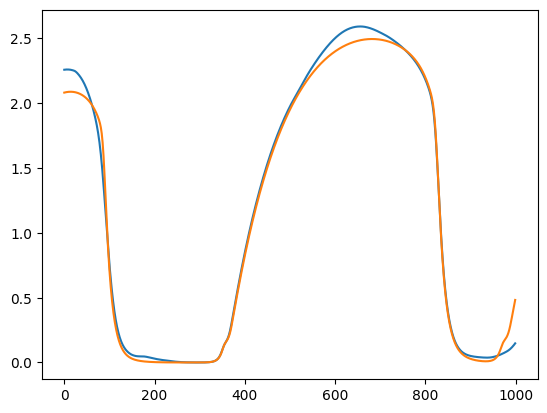

In [15]:
plt.plot( T_rec[0,:])
plt.plot( T_model[0,:])

In [16]:
rel_err = 1        
kwargs_sys = { 
    'nu_min': nu0 - nu0 *rel_err,'nu_max': nu0 + nu0 *rel_err,
    'm_min': m0 - m0 *rel_err,'m_max' : m0 + m0 *rel_err,
    'l_g_min': l_0 - l_0 *rel_err,'l_g_max': l_0 + l_0 *rel_err,
    'k_g_min': k_g0 - k_g0 *rel_err,'k_g_max': k_g0 + k_g0 *rel_err,
    'k_p_min': k_p0 - k_p0 *rel_err,'k_p_max': k_p0 + k_p0 *rel_err,
    'k_a_min': k_a0 - k_a0 *rel_err,'k_a_max': k_a0 + k_a0 *rel_err,
    'c_a_min': c_a0 - c_a0 *rel_err,'c_a_max': c_a0 + c_a0 *rel_err,
    'eta_min': 0,'eta_max': 1,
    't_interp': t_interp,
    'N_interp': N_interp,
    'x_cm':x_cm_interp,
    'x_j':x_j_interp,
    'T':T_interp,
    'x1_0':x_i[0,0],
    'x2_0':x_i[0,1],
    'y1_0':x_i_dot[0,0],
    'y2_0':x_i_dot[0,1],
    'N_sys': 1    
}

#upper and lower bounds for parameters
tol = 1
real_params_low = {'l_g':l_0- l_0*tol,
                   'k_g':k_g0- k_g0*tol,'k_p':k_p0- k_p0*tol,
                   'k_a':k_a0- k_a0*tol,'m':m0- m0*tol,'nu':nu0- nu0*tol,'c_a': c_a0 - c_a0*tol ,'eta0':0,'eta1':0,'eta2':0,'eta3':0}
real_params_up = {'l_g':l_0+ l_0*tol,
                  'k_g':k_g0+ k_g0*tol,'k_p':k_p0+ k_p0*tol,
                  'k_a':k_a0+ k_a0*tol,'m':m0+ m0*tol,'nu':nu0+ nu0*tol,'c_a': c_a0 + c_a0*tol ,'eta':1,'eta1':1,'eta2':1,'eta3':1}

In [17]:

targets = {"x1":x_i[:,0].reshape((1,len(x_i[:,0]))),'x2':x_i[:,1].reshape((1,len(x_i[:,0]))),'y1':x_i_dot[:,0].reshape((1,len(x_i_dot[:,0]))),'y2':x_i_dot[:,1].reshape((1,len(x_i_dot[:,1])))}
reset_every = 300
t_reset_idcs = tuple([
    reset_every * i
    for i in range(int(np.ceil((len(t_evals) - 1) / reset_every)))
])

kwargs_adoptODE = {'lr':.9e-2, 'epochs':100,'N_backups':1,
                #    't_reset_idcs': t_reset_idcs,
                   'lower_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']-0*y0['y1'],'y2':y0['y2']-0*y0['y2'] },
                   'upper_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']+0*y0['y1'],'y2':y0['y2']+0*y0['y2'] },
                   'lower_b': real_params_low,
                   'upper_b': real_params_up}


dataset2 = dataset_adoptODE(sm_model,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE, 
                                true_params = real_params
                                )

In [18]:
params_final, losses, errors, params_history = train_adoptODE(dataset2,save_interval=100)

Epoch 000:  Loss: 1.3e-02,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 2.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 010:  Loss: 2.2e-03,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 2.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 020:  Loss: 1.5e-03,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 2.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 030:  Loss: 1.2e-03,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 2.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 040:  Loss: 1.1e-03,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 2.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 050:  Loss: 8.4e-04,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 2.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 060:  Loss: 5.9e-04,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 2.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 070:  Loss: 3.9e-04,  Params Err.: 1.0e+01, y0 error: na

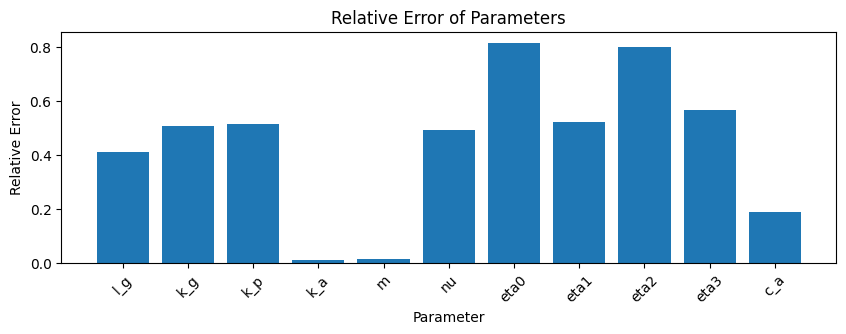

In [19]:
# Get the parameter names
param_names = list(real_params.keys())

# Calculate the relative error for each parameter
relative_errors = []
for param_name in param_names:
    real_value = real_params.get(param_name, np.nan)
    train_value = dataset2.params_train.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)

# Plot the relative errors
plt.figure(figsize=(10, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

In [20]:
print(dataset2.params_train['eta0'],dataset2.params_train['eta1'],dataset2.params_train['eta2'],dataset2.params_train['eta3'])
print(real_params['eta0'],real_params['eta1'],real_params['eta2'],real_params['eta3'])

0.022139156 0.05792862 0.024743428 0.052464016
0.119591296 0.121208906 0.12246919 0.12079996


In [21]:
losses = np.load('../data/SpringMassModel/EtaSweep/eta_sweepT_rec_xl.npy')

/tmp/ipykernel_162046/1836111402.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to make space for the colorbar


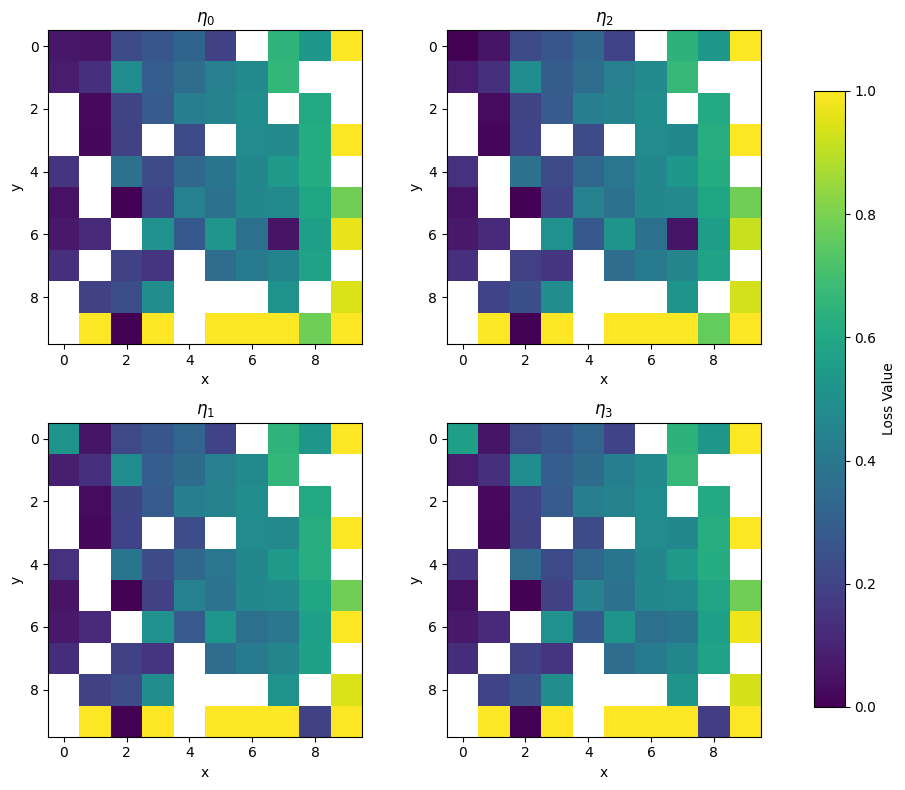

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Find the global vmin and vmax for consistent color scaling
vmin = np.nanmin(losses[:, :, :, 0])
vmax = np.nanmax(losses[:, :, :, 0])

# Create the subplots and use a single colorbar
for i in range(2):
    for j in range(2):
        im = axs[i, j].imshow(
            losses[:, :, i + j * 2, 0],
            cmap='viridis',
            interpolation='nearest',
            vmin=vmin,
            vmax=vmax
        )
        axs[i, j].set_title(f'$\eta_{i + j * 2}$')
        axs[i, j].set_xlabel('x')
        axs[i, j].set_ylabel('y')

# Add a single colorbar outside the figure
cbar = fig.colorbar(
    im,
    ax=axs,
    orientation='vertical',  # 'horizontal' for below the figure
    fraction=0.08,           # Fraction of original axes height
    pad=0.1                  # Padding between the figure and the colorbar
)
cbar.set_label('Loss Value')

plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to make space for the colorbar
plt.show()